<a href="https://colab.research.google.com/github/EladAriel/Tensorflow/blob/main/CIFAR_10_Classification_with_Tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# General Information Regarding the CIFAR-10 Database

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

Since we are dealing with large database, I'm going to use mixed precision training. The mixed precision training uses a combination of single precision (float32) and half-preicison (float16) data types to speed up model training (up 3x on modern GPUs).

For mixed precision training to work, I need access to a GPU with a compute compability score of 7.0+. Google Colab offers T4 GPU.

# Check GPU

In [1]:
# Check GPU
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-28c72589-2465-9949-d62a-198b9f0651d8)


# Check TensorFlow Version

In [5]:
# Check TensorFlow version (should be 2.4.0+)
import tensorflow as tf
print(f"The TensorFlow Version is: {tf.__version__}")

The TensorFlow Version is: 2.8.2


# Downloading and Preprocessing the Data

In [9]:
# Get TensorFlow datasets
import tensorflow_datasets as tfds

# List available datasets
datasets_list = tfds.list_builders() # get all available datasets in TFDS
print("cifar10" in datasets_list) # is the dataset we're after available?

True


### Load the Data

In [10]:
# Load in the data
(test_data, train_data), ds_info = tfds.load(name="cifar10",                                           
                                             split=['test','train'],
                                             shuffle_files=True,
                                             as_supervised=True,
                                             with_info=True)

# Print information about the dataset
num_train = len(train_data)
num_test  = len(test_data)
num_examples = num_test + num_train
num_classes = ds_info.features["label"].num_classes
class_names = ds_info.features["label"].names

print(f'\nNumber of examples: {num_examples} \
        \nNumber of train images: {num_train} \
        \nNumber of test images: {num_test} \
        \nNum of classes: {num_classes} \
        \nClass names: {class_names}')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/cifar10/3.0.2.incompleteV6UDKG/cifar10-train.tfrecord*...:   0%|          | 0/…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/cifar10/3.0.2.incompleteV6UDKG/cifar10-test.tfrecord*...:   0%|          | 0/1…

Dataset cifar10 downloaded and prepared to ~/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.

Number of examples: 60000         
Number of train images: 50000         
Number of test images: 10000         
Num of classes: 10         
Class names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


### Exploring the CIFAR-10 Data from TensorFlow Datasets

In [11]:
# Take one sample off the training data
train_sample = train_data.take(1)

# Output info about our training sample
for image, label in train_sample:
  print(f"""
  Image shape: {image.shape}
  Image dtype: {image.dtype}
  Target class from CIFAR-100 (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
        """)


  Image shape: (32, 32, 3)
  Image dtype: <dtype: 'uint8'>
  Target class from CIFAR-100 (tensor form): 7
  Class name (str form): horse
        


In [12]:
# What does an image tensor from TFDS's cifar10 look like?
image

<tf.Tensor: shape=(32, 32, 3), dtype=uint8, numpy=
array([[[143,  96,  70],
        [141,  96,  72],
        [135,  93,  72],
        ...,
        [ 96,  37,  19],
        [105,  42,  18],
        [104,  38,  20]],

       [[128,  98,  92],
        [146, 118, 112],
        [170, 145, 138],
        ...,
        [108,  45,  26],
        [112,  44,  24],
        [112,  41,  22]],

       [[ 93,  69,  75],
        [118,  96, 101],
        [179, 160, 162],
        ...,
        [128,  68,  47],
        [125,  61,  42],
        [122,  59,  39]],

       ...,

       [[187, 150, 123],
        [184, 148, 123],
        [179, 142, 121],
        ...,
        [198, 163, 132],
        [201, 166, 135],
        [207, 174, 143]],

       [[187, 150, 117],
        [181, 143, 115],
        [175, 136, 113],
        ...,
        [201, 164, 132],
        [205, 168, 135],
        [207, 171, 139]],

       [[195, 161, 126],
        [187, 153, 123],
        [186, 151, 128],
        ...,
        [212, 177, 147]

In [15]:
# What are the min and max values?
print(f"The image min value is: {tf.reduce_min(image)}")
print(f"The image max value is: {tf.reduce_max(image)}")

The image min value is: 0
The image max value is: 249


### Plot an image from TFDS

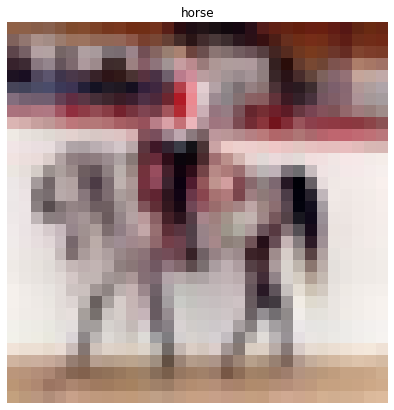

In [16]:
# Plot an image tensor
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 7))
plt.imshow(image)
plt.title(class_names[label]) # add title to image by indexing on class_names list
plt.axis(False);

### Create Preprocessing Functions for Our Data

A few notes:

our data is currently:
*   In `uint8` data type
*   Comprised of different sized images
*   Not scaled

our data shoud be:
*   In `float32` data type (or `float16`)
*   Comprised of images with the same size
*   scaled

In [17]:
# Make a function for preprocessing images
def preprocess_img(image, label, img_shape):
  """
  Reshapes image to [img_shape, img_shape, color_channels],
  Converts image datatype from 'uint8' -> 'float32' and normalize it,
  One hot encode the label

  Args:
    image: An image from the dataset
    label: The corresponding label to the image
    img_shape: Set the image shape

  Returns:
    (float32_image, label) tuple
  """
  image = tf.image.resize(image, [img_shape, img_shape]) # reshape to img_shape
  return tf.cast(image, tf.float32)/255., tf.one_hot(label, depth=num_classes)

In [18]:
# Preprocess a single sample image and check the outputs
preprocessed_img = preprocess_img(image, label, img_shape=224)[0]
print(f"Image before preprocessing:\n {image[:2]}...,\n\nShape: {image.shape},\n\nDatatype: {image.dtype}\n")
print(f"Image after preprocessing:\n {preprocessed_img[:2]}...,\n\nShape: {preprocessed_img.shape},\n\nDatatype: {preprocessed_img.dtype}")

Image before preprocessing:
 [[[143  96  70]
  [141  96  72]
  [135  93  72]
  [136  96  78]
  [131  86  63]
  [127  74  44]
  [131  75  46]
  [124  65  38]
  [117  54  29]
  [121  55  30]
  [113  45  20]
  [112  46  21]
  [116  50  29]
  [ 88  31  23]
  [ 42  12  16]
  [ 30  14  20]
  [ 34  20  23]
  [ 26  16  19]
  [ 18   9  14]
  [ 21   7  16]
  [ 42  15  24]
  [ 83  28  26]
  [ 96  32  21]
  [100  35  19]
  [ 99  30  13]
  [104  31  18]
  [105  31  16]
  [ 97  28  20]
  [ 86  23  20]
  [ 96  37  19]
  [105  42  18]
  [104  38  20]]

 [[128  98  92]
  [146 118 112]
  [170 145 138]
  [163 140 133]
  [155 124 110]
  [155 114  93]
  [156 115  95]
  [146 104  86]
  [145 103  86]
  [147 102  87]
  [141  87  72]
  [120  63  46]
  [121  71  53]
  [101  64  52]
  [ 67  43  39]
  [ 42  21  22]
  [ 65  43  44]
  [ 74  57  57]
  [ 60  45  46]
  [ 42  23  29]
  [ 43  16  23]
  [ 55  16  17]
  [ 76  30  22]
  [103  47  30]
  [111  45  22]
  [118  45  24]
  [114  45  23]
  [102  37  25]
  [ 93  2

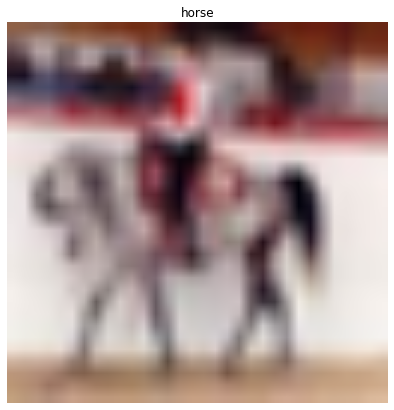

In [19]:
# Plot an image tensor
plt.figure(figsize=(10, 7))
plt.imshow(preprocessed_img)
plt.title(class_names[label])
plt.axis(False);

### Batch & Prepare the CIFAR-10 Dataset

The purpose is to turn the data into batches, since computing on batches is memory efficient.
I'm turning the data into batches of 32 image and label pairs,thus enabling it to fit into the memory of the GPU.

`map()` - maps the preprocess_img function to the CIFAR-10 dataset.

`shuffle()` - randomaly shuffles the elements of the CIFAR-10 up buffer_size.

`batch()` - turns elements of the CIFAR-10 dataset into batches.

`prefetch()` - prepares subsequent batches of data whilst other batches of data are being computed on.

In [20]:
def preprocess_data(train, test, batch_size, img_shape):
  """
  Turn the data into batches, since computing on batches is memory efficient.

  Args:
    train: Set train dataset
    test : Set test dataset
    batch_size: Set batch_size. For our model it will be set to 32.
    img_shape: Set the image shape

  Returns:
    (train_data, test_data) tuple
  """
  # Map preprocessing function to training data (and paralellize)
  train_data = train.map(lambda image, label: preprocess_img(image, label, img_shape), num_parallel_calls=tf.data.AUTOTUNE)

  # Shuffle train_data and turn it into batches and prefetch it (load it faster)
  train_data = train_data.shuffle(buffer_size=1000).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

  # Map prepreprocessing function to test data
  test_data = test.map(lambda image, label: preprocess_img(image, label, img_shape), num_parallel_calls=tf.data.AUTOTUNE)

  # Turn test data into batches (don't need to shuffle)
  test_data = test_data.batch(batch_size).prefetch(tf.data.AUTOTUNE)

  return train_data, test_data

In [33]:
# Run preprocessing function
train_224, test_224 = preprocess_data(train=train_data, test=test_data, batch_size=32, img_shape=224)
train_331, test_331 = preprocess_data(train=train_data, test=test_data, batch_size=32, img_shape=331)

# See how the data looks like after preprocessing
print(f"Train data image shape after preprocessing is: {train_224.element_spec[0].shape}")
print(f"Train data image type after preprocessing is: {train_224.element_spec[0].dtype}")
print(f"\nTrain data label shape after preprocessing is: {train_224.element_spec[1].shape}")
print(f"Train data label type after preprocessing is: {train_224.element_spec[1].dtype}")
print(f"\nTest data image shape after preprocessing is: {test_224.element_spec[0].shape}")
print(f"Test data image type after preprocessing is: {test_224.element_spec[0].dtype}")
print(f"\nTest data label shape after preprocessing is: {test_224.element_spec[1].shape}")
print(f"Test data label type after preprocessing is: {test_224.element_spec[1].dtype}")

Train data image shape after preprocessing is: (None, 224, 224, 3)
Train data image type after preprocessing is: <dtype: 'float32'>

Train data label shape after preprocessing is: (None, 10)
Train data label type after preprocessing is: <dtype: 'float32'>

Test data image shape after preprocessing is: (None, 224, 224, 3)
Test data image type after preprocessing is: <dtype: 'float32'>

Test data label shape after preprocessing is: (None, 10)
Test data label type after preprocessing is: <dtype: 'float32'>


### Create Modelling Callbacks

In [34]:
# Get helper fucntion that i've used in 'mrdbourke/tensorflow-deep-learning' course
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Create TensorBoard callback
from helper_functions import create_tensorboard_callback

# Create ModelCheckpoint callback to save model's progress
checkpoint_path = "model_checkpoints/cp.ckpt" # saving weights requires ".ckpt" extension
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_acc",
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      verbose=0)

--2022-09-26 11:08:46--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-09-26 11:08:46 (85.1 MB/s) - ‘helper_functions.py’ saved [10246/10246]



### Setup Mixed Precision Training

In [35]:
# Turn on mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy(policy="mixed_float16") # set global policy to mixed precision

# Check the global dtype policy 
mixed_precision.global_policy()

<Policy "mixed_float16">

# Build Model

In [36]:
# List all available models
import inspect
model_dictionary = {m[0]:m[1] for m in inspect.getmembers(tf.keras.applications, inspect.isfunction)}
model_dictionary.keys()

dict_keys(['DenseNet121', 'DenseNet169', 'DenseNet201', 'EfficientNetB0', 'EfficientNetB1', 'EfficientNetB2', 'EfficientNetB3', 'EfficientNetB4', 'EfficientNetB5', 'EfficientNetB6', 'EfficientNetB7', 'EfficientNetV2B0', 'EfficientNetV2B1', 'EfficientNetV2B2', 'EfficientNetV2B3', 'EfficientNetV2L', 'EfficientNetV2M', 'EfficientNetV2S', 'InceptionResNetV2', 'InceptionV3', 'MobileNet', 'MobileNetV2', 'MobileNetV3Large', 'MobileNetV3Small', 'NASNetLarge', 'NASNetMobile', 'ResNet101', 'ResNet101V2', 'ResNet152', 'ResNet152V2', 'ResNet50', 'ResNet50V2', 'VGG16', 'VGG19', 'Xception'])

## Model 0: Feature Extraction Model

### Find the Best Pre-Trained Model

#### Create a Model and Compile it

In [37]:
# Import the required modules for model creation
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

In [38]:
def create_model(num_classes, model_name, model):
  """
  Create a deep learning model based on user specifications.

  Args:
    input_shape: Set the image shape)
    num_classes: The number of classes of the dataset.
    class_names: Array of class labels (e.g. string form).
    base_model_name: The base model name to use.
    model_name: The model name.
    
  Returns:
    The model
  """
  # Some pre-trained models require images to be of size (224,224,3) while some require (331,331,3).
  # "NASNetLarge" requires input images with size (331,331)
  if 'NASNetLarge' in model_name:
    input_shape  = (331, 331, 3)
    train_data = train_331
    test_data  = test_331
  else:
    input_shape  = (224, 224, 3)
    train_data = train_224
    test_data  = test_224
  
  # Create base model
  base_model = model(include_top=False, classes=num_classes)
  base_model.trainable = False # freeze base model layers
  num_model_params = base_model.count_params()

  # Create Functional model 
  inputs = layers.Input(shape=input_shape, name="input_layer")
  x = base_model(inputs, training=False) # set base_model to inference mode only
  x = layers.GlobalMaxPooling2D(name="pooling_layer")(x)
  outputs = layers.Dense(num_classes,
                        activation="softmax",
                        dtype=tf.float32,
                        name="softmax_float32")(x)
  model = tf.keras.Model(inputs, outputs, name="feature_extraction_model")

  # Compile the model
  model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=["accuracy"])

  # return the model
  return train_data, test_data, model, num_model_params

#### Fit the Feature Extraction Model

To save time in choosing the best pre-trained model, the model has been fitted for 10% of the dataset.

In [ ]:
# Loop over each model available in Keras
model_benchmarks = {'model_name': [], 'num_model_params': [], 'validation_accuracy': []}

for model_name, model in model_dictionary.items():
  # compile the model
  train_data, test_data, model, num_model_params = create_model(num_classes, model_name, model)

  # Fit the model
  print(f"\nThe model name is: {model_name}")
  history_cifar10_feature_extract = model.fit(train_data,
                                              steps_per_epoch=int(0.1 * len(train_data)),
                                              epochs=3,
                                              validation_data=test_data,
                                              validation_steps=int(0.1 * len(test_data)))
  
  # Calculate all relevant metrics
  model_benchmarks['model_name'].append(model_name)
  model_benchmarks['num_model_params'].append(num_model_params)
  model_benchmarks['validation_accuracy'].append(history_cifar10_feature_extract.history['val_accuracy'][-1])


The model name is: DenseNet121
Epoch 1/3
156/156 [==============================] - 20s 82ms/step - loss: 1.9014 - accuracy: 0.4577 - val_loss: 1.1859 - val_accuracy: 0.6169
Epoch 2/3
156/156 [==============================] - 11s 73ms/step - loss: 1.0738 - accuracy: 0.6591 - val_loss: 0.8905 - val_accuracy: 0.7046
Epoch 3/3
156/156 [==============================] - 11s 69ms/step - loss: 0.9075 - accuracy: 0.7051 - val_loss: 0.8028 - val_accuracy: 0.7339

The model name is: DenseNet169
Epoch 1/3
156/156 [==============================] - 27s 119ms/step - loss: 1.5762 - accuracy: 0.5415 - val_loss: 1.0477 - val_accuracy: 0.6643
Epoch 2/3
156/156 [==============================] - 16s 106ms/step - loss: 0.8885 - accuracy: 0.7155 - val_loss: 0.8260 - val_accuracy: 0.7369
Epoch 3/3
156/156 [==============================] - 15s 98ms/step - loss: 0.8261 - accuracy: 0.7386 - val_loss: 0.7393 - val_accuracy: 0.7641

The model name is: DenseNet201
Epoch 1/3
156/156 [=========================

17235968/17225924 [==============================] - 0s 0us/step

The model name is: MobileNet
Epoch 1/3
156/156 [==============================] - 9s 44ms/step - loss: 2.6565 - accuracy: 0.4383 - val_loss: 1.2478 - val_accuracy: 0.6421
Epoch 2/3
156/156 [==============================] - 6s 38ms/step - loss: 1.2372 - accuracy: 0.6621 - val_loss: 1.0956 - val_accuracy: 0.6905
Epoch 3/3
156/156 [==============================] - 6s 39ms/step - loss: 1.0878 - accuracy: 0.7139 - val_loss: 0.9413 - val_accuracy: 0.7369


9420800/9406464 [==============================] - 0s 0us/step

The model name is: MobileNetV2
Epoch 1/3
156/156 [==============================] - 10s 45ms/step - loss: 2.2724 - accuracy: 0.4858 - val_loss: 1.3795 - val_accuracy: 0.6361
Epoch 2/3
156/156 [==============================] - 6s 40ms/step - loss: 1.3119 - accuracy: 0.6573 - val_loss: 1.2789 - val_accuracy: 0.6673
Epoch 3/3
156/156 [==============================] - 6s 41ms/step - loss: 1.1627 - accuracy: 0.6851 - val_loss: 1.0511 - val_accuracy: 0.7298


12697600/12683000 [==============================] - 0s 0us/step

The model name is: MobileNetV3Large
Epoch 1/3
156/156 [==============================] - 12s 50ms/step - loss: 2.4095 - accuracy: 0.1052 - val_loss: 2.3026 - val_accuracy: 0.1079
Epoch 2/3
156/156 [==============================] - 7s 44ms/step - loss: 2.3088 - accuracy: 0.1156 - val_loss: 2.2978 - val_accuracy: 0.1038
Epoch 3/3
156/156 [==============================] - 7s 43ms/step - loss: 2.2964 - accuracy: 0.1178 - val_loss: 2.2800 - val_accuracy: 0.0988


4349952/4334752 [==============================] - 0s 0us/step

The model name is: MobileNetV3Small
Epoch 1/3
156/156 [==============================] - 11s 46ms/step - loss: 2.3421 - accuracy: 0.1020 - val_loss: 2.3243 - val_accuracy: 0.0857
Epoch 2/3
156/156 [==============================] - 7s 46ms/step - loss: 2.3160 - accuracy: 0.1048 - val_loss: 2.3203 - val_accuracy: 0.1048
Epoch 3/3
343621632/343610240 [==============================] - 13s 0us/step

The model name is: NASNetLarge
Epoch 1/3
156/156 [==============================] - 116s 611ms/step - loss: 1.7852 - accuracy: 0.7498 - val_loss: 1.1590 - val_accuracy: 0.8196
Epoch 2/3
156/156 [==============================] - 90s 577ms/step - loss: 1.2020 - accuracy: 0.8337 - val_loss: 1.2192 - val_accuracy: 0.8286
Epoch 3/3
20004864/19993432 [==============================] - 1s 0us/step

The model name is: NASNetMobile
Epoch 1/3
156/156 [==============================] - 33s 126ms/step - loss: 1.5574 - accuracy: 0.6246 - val_

In [ ]:
# Compare between the models and fine the best model to solve the classification problem
# Convert Results to DataFrame for easy viewing
import pandas as pd
df_results = pd.DataFrame(model_benchmarks)

# sort in ascending order of num_model_params column
df_results.sort_values('validation_accuracy', inplace=True, ascending=False)

# Print the DataFrame
df_results

,model_name,num_model_params,validation_accuracy
24,NASNetLarge,84916818,0.863911
18,InceptionResNetV2,54336736,0.820565
2,DenseNet201,18321984,0.804435
29,ResNet152V2,58331648,0.795363
34,Xception,20861480,0.791331
27,ResNet101V2,42626560,0.786290
25,NASNetMobile,4269716,0.782258
31,ResNet50V2,23564800,0.777218
1,DenseNet169,12642880,0.764113
19,InceptionV3,21802784,0.760081


### Run the Chosen Model Using All Dataset

20004864/19993432 [==============================] - 0s 0us/step
Saving TensorBoard log files to: training_logs/cifar10_feature_extract/20220924-135213
Epoch 1/3
1563/1563 [==============================] - ETA: 0s - loss: 0.8802 - accuracy: 0.7652

1563/1563 [==============================] - 193s 107ms/step - loss: 0.8802 - accuracy: 0.7652 - val_loss: 0.8908 - val_accuracy: 0.7678
Epoch 2/3
1563/1563 [==============================] - ETA: 0s - loss: 0.6435 - accuracy: 0.8127

1563/1563 [==============================] - 177s 113ms/step - loss: 0.6435 - accuracy: 0.8127 - val_loss: 0.7439 - val_accuracy: 0.7968
Epoch 3/3
1563/1563 [==============================] - ETA: 0s - loss: 0.6007 - accuracy: 0.8239

1563/1563 [==============================] - 178s 113ms/step - loss: 0.6007 - accuracy: 0.8239 - val_loss: 0.7617 - val_accuracy: 0.7916


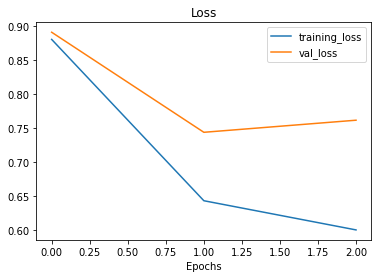

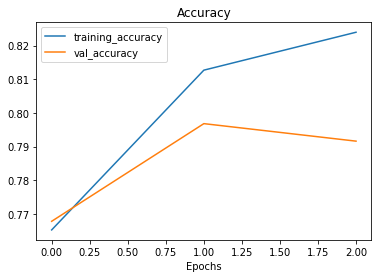

In [ ]:
model_name = 'NASNetMobile'
model = model_dictionary[model_name]

# compile the model
train_data, test_data, model_0, num_model_params = create_model(num_classes, model_name, model)

# Fit the model with callbacks
history_cifar10_feature_extract = model_0.fit(train_data,
                                              steps_per_epoch=len(train_data),
                                              epochs=3,
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=[create_tensorboard_callback("training_logs", "cifar10_feature_extract"),
                                                         model_checkpoint])

# Plots loss curves
from helper_functions import plot_loss_curves
plot_loss_curves(history_cifar10_feature_extract)

In [ ]:
# Evaluate model on whole test dataset
results_feature_extract_model = model_0.evaluate(test_data)
results_feature_extract_model

313/313 [==============================] - 26s 83ms/step - loss: 0.7617 - accuracy: 0.7916


[0.7616820931434631, 0.7915999889373779]

### Save the Model

In [ ]:
# Save model to drive so it can be used later 
model_0.save("drive/My Drive/Colab Notebooks/NASNetMobile_model_0")

### Load the Model

In [39]:
# Load in from Google Drive
model_0 = tf.keras.models.load_model('drive/My Drive/Colab Notebooks/NASNetMobile_model_0')

In [40]:
# Check out our loaded model
model_0.summary()

Model: "feature_extraction_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 NASNet (Functional)         (None, 7, 7, 1056)        4269716   
                                                                 
 pooling_layer (GlobalMaxPoo  (None, 1056)             0         
 ling2D)                                                         
                                                                 
 softmax_float32 (Dense)     (None, 10)                10570     
                                                                 
Total params: 4,280,286
Trainable params: 10,570
Non-trainable params: 4,269,716
_________________________________________________________________


In [41]:
# Check layer dtype policies (are we using mixed precision?)
# Check the dtype_policy attributes of layers in our model
for layer in model_0.layers:
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy) # Check the dtype policy of layers

input_layer True float32 <Policy "float32">
NASNet False float32 <Policy "mixed_float16">
pooling_layer True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


In [43]:
# Check the same details for our model's base model (NASNetMobile)
for layer in model_0.layers[1].layers[:20]: # only check the first 20 layers to save output space
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 True float32 <Policy "float32">
stem_conv1 False float32 <Policy "mixed_float16">
stem_bn1 False float32 <Policy "mixed_float16">
activation False float32 <Policy "mixed_float16">
reduction_conv_1_stem_1 False float32 <Policy "mixed_float16">
reduction_bn_1_stem_1 False float32 <Policy "mixed_float16">
activation_1 False float32 <Policy "mixed_float16">
activation_3 False float32 <Policy "mixed_float16">
separable_conv_1_pad_reduction_left1_stem_1 False float32 <Policy "mixed_float16">
separable_conv_1_pad_reduction_right1_stem_1 False float32 <Policy "mixed_float16">
separable_conv_1_reduction_left1_stem_1 False float32 <Policy "mixed_float16">
separable_conv_1_reduction_right1_stem_1 False float32 <Policy "mixed_float16">
separable_conv_1_bn_reduction_left1_stem_1 False float32 <Policy "mixed_float16">
separable_conv_1_bn_reduction_right1_stem_1 False float32 <Policy "mixed_float16">
activation_2 False float32 <Policy "mixed_float16">
activation_4 False float32 <Policy "mixed

### Predictions

In [ ]:
# Make predictions with model
pred_probs = model_0.predict(test_data, verbose=1)

# Get the class predicitons of each label
pred_classes = tf.argmax(pred_probs, axis=1)

y_labels = []
for images, labels in test_data.unbatch(): # unbatch the test data and get images and labels
  y_labels.append(labels.numpy().argmax()) # append the index which has the largest value (labels are one-hot)

from helper_functions import calculate_results
model_results = calculate_results(y_true=y_labels,
                                  y_pred=pred_classes)
model_results

313/313 [==============================] - 28s 76ms/step


{'accuracy': 79.16,
 'precision': 0.8122793717427141,
 'recall': 0.7916,
 'f1': 0.7913099109508638}

## Model 1: Fine-Tuned Model

According to https://www.tensorflow.org/tutorials/images/transfer_learning:

In the feature extraction experiment, I was only training a few layers on top of an NASNetMobile base model. The weights of the pre-trained network were not updated during training.

One way to increase performance even further is to train the weights of the top layers of the pre-trained model alongside the training of the classifier you added. The training process will force the weights to be tuned from generic feature maps to features associated specifically with the dataset.

### Fine-Tuning Callbacks

In [45]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                  patience=3)

# Create ModelCheckpoint callback to save best model during fine-tuning
checkpoint_path = "fine_tune_checkpoints/"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      save_best_only=True,
                                                      monitor="val_loss")

# Creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2,
                                                 verbose=1, # print out when learning rate goes down 
                                                 min_lr=1e-7)

### Fit the Fine-Tuning Model

In [46]:
def create_model_fine_tuning(num_classes, model_name, model):
  """
  Create a deep learning model based on user specifications.

  Args:
    input_shape: Set the image shape)
    num_classes: The number of classes of the dataset.
    class_names: Array of class labels (e.g. string form).
    base_model_name: The base model name to use.
    model_name: The model name.
    
  Returns:
    The model
  """
  # Some pre-trained models require images to be of size (224,224,3) while some require (331,331,3).
  # "NASNetLarge" requires input images with size (331,331)
  if 'NASNetLarge' in model_name:
    input_shape  = (331, 331, 3)
    train_data = train_331
    test_data  = test_331
  else:
    input_shape  = (224, 224, 3)
    train_data = train_224
    test_data  = test_224
  
  # Create base model
  base_model = model(include_top=False, classes=num_classes)
  base_model.trainable = True # freeze base model layers
  num_model_params = base_model.count_params()

  # Create Functional model 
  inputs = layers.Input(shape=input_shape, name="input_layer")
  x = base_model(inputs, training=False) # set base_model to inference mode only
  x = layers.GlobalMaxPooling2D(name="pooling_layer")(x)
  outputs = layers.Dense(num_classes,
                        activation="softmax",
                        dtype=tf.float32,
                        name="softmax_float32")(x)
  model = tf.keras.Model(inputs, outputs, name="feature_extraction_model")

  # Compile the model
  model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                  optimizer=tf.keras.optimizers.Adam(0.0001),
                  metrics=["accuracy"])

  # return the model
  return train_data, test_data, model, num_model_params

20004864/19993432 [==============================] - 2s 0us/step
Saving TensorBoard log files to: training_logs/cifar10_fine_tuning/20220925-120335
Epoch 1/100
1563/1563 [==============================] - 511s 295ms/step - loss: 0.4551 - accuracy: 0.8580 - val_loss: 0.3204 - val_accuracy: 0.8889 - lr: 1.0000e-04
Epoch 2/100
1563/1563 [==============================] - 446s 284ms/step - loss: 0.1822 - accuracy: 0.9387 - val_loss: 0.1871 - val_accuracy: 0.9392 - lr: 1.0000e-04
Epoch 3/100
1563/1563 [==============================] - 454s 290ms/step - loss: 0.1313 - accuracy: 0.9550 - val_loss: 0.1727 - val_accuracy: 0.9456 - lr: 1.0000e-04
Epoch 4/100
1563/1563 [==============================] - 331s 212ms/step - loss: 0.0996 - accuracy: 0.9665 - val_loss: 0.2394 - val_accuracy: 0.9297 - lr: 1.0000e-04
Epoch 5/100
1563/1563 [==============================] - ETA: 0s - loss: 0.0775 - accuracy: 0.9740
Epoch 5: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
1563/1563 [=

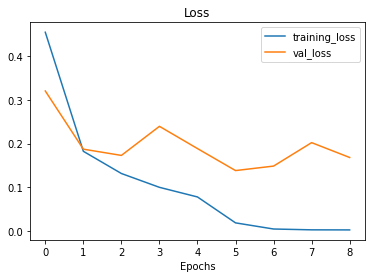

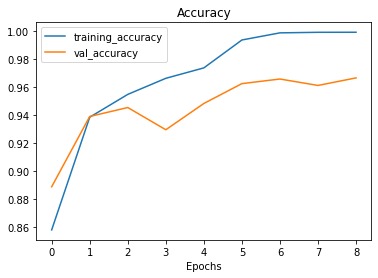

In [ ]:
model_name = 'NASNetMobile'
model = model_dictionary[model_name]

# compile the model
train_data, test_data, model_1, _ = create_model_fine_tuning(num_classes, model_name, model)

# Start to fine-tune ,all trainable
history_cifar10_fine_tune = model_1.fit(train_data,
                                        epochs=100, # fine-tune for a maximum of 100 epochs
                                        steps_per_epoch=len(train_data),
                                        validation_data=test_data,
                                        validation_steps=len(test_data),
                                        callbacks=[create_tensorboard_callback("training_logs", "cifar10_fine_tuning"), # track the model training logs
                                                   model_checkpoint, # save only the best model during training
                                                   early_stopping, # stop model after X epochs of no improvements
                                                   reduce_lr]) # reduce the learning rate after X epochs of no improvements

# Plots loss curves
from helper_functions import plot_loss_curves
plot_loss_curves(history_cifar10_fine_tune)

In [ ]:
# Evaluate model on whole test dataset
results_feature_extract_model = model_1.evaluate(test_data)
results_feature_extract_model

313/313 [==============================] - 25s 81ms/step - loss: 0.1680 - accuracy: 0.9668


[0.16796568036079407, 0.9667999744415283]

#### Save the Model

In [ ]:
# Save model to drive so it can be used later 
model_1.save("drive/My Drive/Colab Notebooks/NASNetMobile_model_1")

#### Load the Model

In [47]:
# Load in from Google Drive
model_1 = tf.keras.models.load_model('drive/My Drive/Colab Notebooks/NASNetMobile_model_1')

In [48]:
# Check out our loaded model
model_1.summary()

Model: "feature_extraction_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 NASNet (Functional)         (None, 7, 7, 1056)        4269716   
                                                                 
 pooling_layer (GlobalMaxPoo  (None, 1056)             0         
 ling2D)                                                         
                                                                 
 softmax_float32 (Dense)     (None, 10)                10570     
                                                                 
Total params: 4,280,286
Trainable params: 4,243,548
Non-trainable params: 36,738
_________________________________________________________________


In [49]:
# Check layer dtype policies (are we using mixed precision?)
# Check the dtype_policy attributes of layers in our model
for layer in model_1.layers:
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy) # Check the dtype policy of layers

input_layer True float32 <Policy "float32">
NASNet True float32 <Policy "mixed_float16">
pooling_layer True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


In [50]:
# Check the same details for our model's base model (NASNetMobile)
for layer in model_1.layers[1].layers[:20]: # only check the first 20 layers to save output space
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 True float32 <Policy "float32">
stem_conv1 True float32 <Policy "mixed_float16">
stem_bn1 True float32 <Policy "mixed_float16">
activation True float32 <Policy "mixed_float16">
reduction_conv_1_stem_1 True float32 <Policy "mixed_float16">
reduction_bn_1_stem_1 True float32 <Policy "mixed_float16">
activation_1 True float32 <Policy "mixed_float16">
activation_3 True float32 <Policy "mixed_float16">
separable_conv_1_pad_reduction_left1_stem_1 True float32 <Policy "mixed_float16">
separable_conv_1_pad_reduction_right1_stem_1 True float32 <Policy "mixed_float16">
separable_conv_1_reduction_left1_stem_1 True float32 <Policy "mixed_float16">
separable_conv_1_reduction_right1_stem_1 True float32 <Policy "mixed_float16">
separable_conv_1_bn_reduction_left1_stem_1 True float32 <Policy "mixed_float16">
separable_conv_1_bn_reduction_right1_stem_1 True float32 <Policy "mixed_float16">
activation_2 True float32 <Policy "mixed_float16">
activation_4 True float32 <Policy "mixed_float16">
sepa

### Predictions

In [ ]:
# Make predictions with model
pred_probs = model_1.predict(test_data, verbose=1)

# Get the class predicitons of each label
pred_classes = tf.argmax(pred_probs, axis=1)

y_labels = []
for images, labels in test_data.unbatch(): # unbatch the test data and get images and labels
  y_labels.append(labels.numpy().argmax()) # append the index which has the largest value (labels are one-hot)

from helper_functions import calculate_results
model_results = calculate_results(y_true=y_labels,
                                  y_pred=pred_classes)
model_results

313/313 [==============================] - 26s 70ms/step


{'accuracy': 96.67999999999999,
 'precision': 0.9667747224069024,
 'recall': 0.9668,
 'f1': 0.9667806746101947}

# Model Predictions Evaluation

## Confusion Matrix

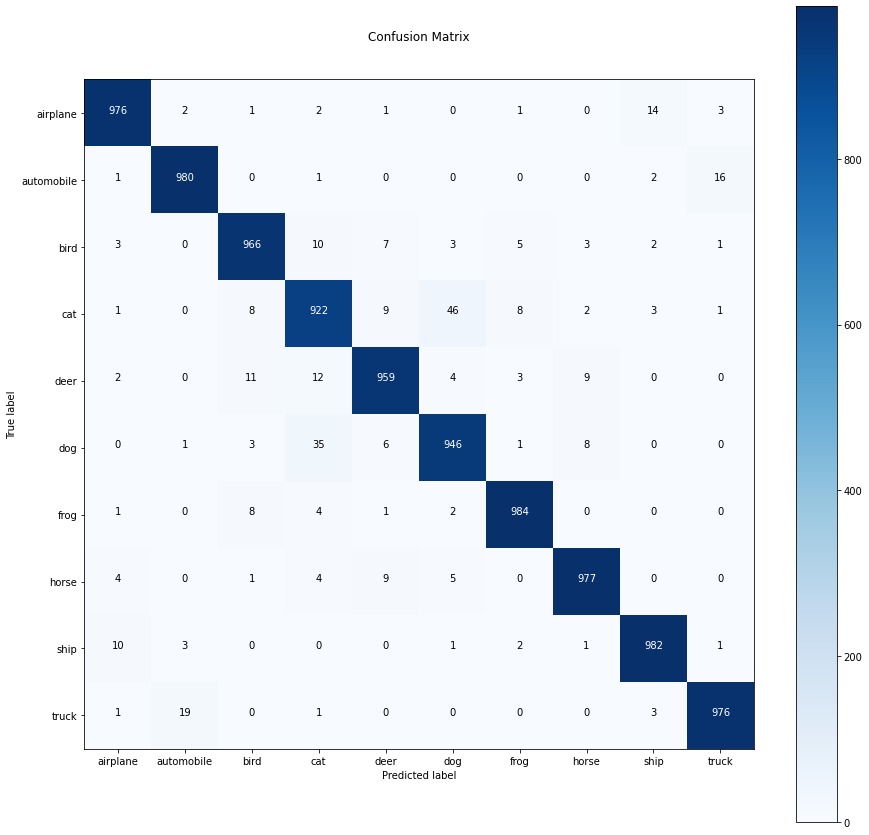

In [ ]:
from helper_functions import make_confusion_matrix
# Plot a confusion matrix with all predictions, ground truth labels and 10 classes
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(15, 15),
                      text_size=10,
                      norm=False,
                      savefig=True)

The confusion matrix gives us insight into which classes its getting "confused" on.

The majority of the predictions are right down the top left to bottom right diagonal, meaning they're correct.

It looks like the model gets most confused on classes like: dog and cat, cat and deer, bird and deer.

## Classification Report

In [ ]:
from sklearn.metrics import classification_report
# Get a dictionary of the classification report
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)

# Create empty dictionary
class_f1_scores = {}
# Loop through classification report items
for k, v in classification_report_dict.items():
  if k == "accuracy": # stop once we get to accuracy key
    break
  else:
    # Append class names and f1-scores to new dictionary
    class_f1_scores[class_names[int(k)]] = v["f1-score"]

# Turn f1-scores into dataframe for visualization
import pandas as pd
f1_scores = pd.DataFrame({"class_name": list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)
f1_scores

,class_name,f1-score
6,frog,0.982036
8,ship,0.979063
1,automobile,0.977556
7,horse,0.977000
9,truck,0.976977
0,airplane,0.976488
2,bird,0.966967
4,deer,0.962851
5,dog,0.942701
3,cat,0.926168


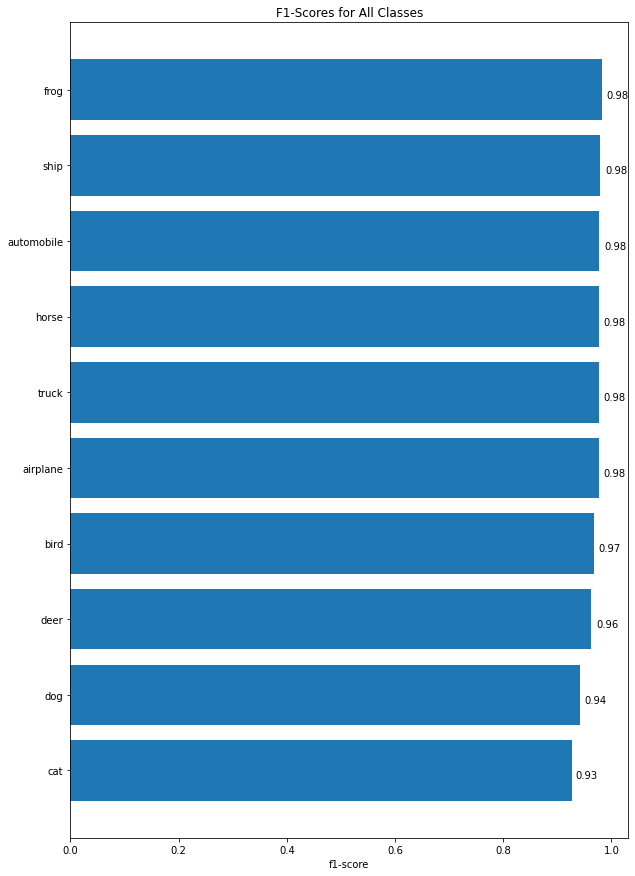

In [ ]:
# Nice horizontal bar chart
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 15))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(list(f1_scores["class_name"]))
ax.set_xlabel("f1-score")
ax.set_title("F1-Scores for All Classes")
ax.invert_yaxis(); # reverse the order

def autolabel(rects): # Modified version of: https://matplotlib.org/examples/api/barchart_demo.html
  """
  Attach a text label above each bar displaying its height (it's value).
  """
  for rect in rects:
    width = rect.get_width()
    ax.text(1.03*width, rect.get_y() + rect.get_height()/1.5,
            f"{width:.2f}",
            ha='center', va='bottom')

autolabel(scores)

It seems like our model performs fairly poorly on classes like `cat` and `dog` while for classes like `frog` and `ship` the performance is quite outstanding.

## Visualizing Predictions on Test Images

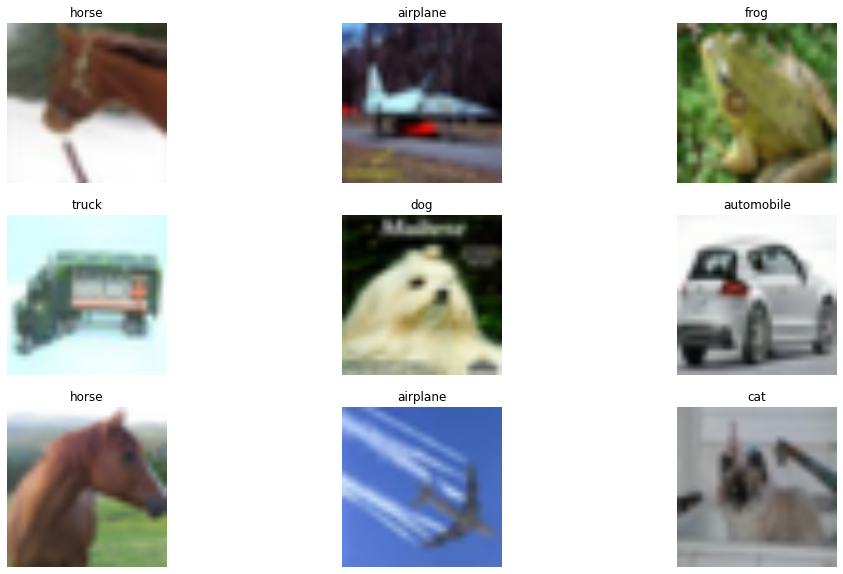

In [ ]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_data.as_numpy_iterator().next()

plt.figure(figsize=(17, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i])
  plt.title(class_names[pred_classes[i]])
  plt.axis(False);

## Finding the Most Wrong Predictions

In [ ]:
# Create a dataframe out of current prediction data for analysis
import pandas as pd
pred_df = pd.DataFrame({"y_true": y_labels,
                        "y_pred": pred_classes,
                        "pred_conf": pred_probs.max(axis=1), # get the maximum prediction probability value
                        "y_true_classname": [class_names[i] for i in y_labels],
                        "y_pred_classname": [class_names[i] for i in pred_classes]}) 

# Is the prediction correct?
pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"]

# Get the top 100 wrong examples
top_100_wrong = pred_df[pred_df["pred_correct"] == False].sort_values("pred_conf", ascending=False)[:100]
top_100_wrong.head(20)

,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname,pred_correct
6060,3,6,1.000000,cat,frog,False
4888,9,1,1.000000,truck,automobile,False
8240,5,3,1.000000,dog,cat,False
1835,4,2,1.000000,deer,bird,False
5558,1,9,1.000000,automobile,truck,False
6888,3,5,1.000000,cat,dog,False
966,1,9,1.000000,automobile,truck,False
8664,6,3,1.000000,frog,cat,False
1469,3,5,0.999999,cat,dog,False
4759,5,3,0.999999,dog,cat,False
